# 03wk-2: 딥러닝의 기초 (1)

최규빈  
2022-09-20

> 회귀분석(1)– 회귀모형의 소개, 회귀모형에서 데이터생성, 회귀모형에서
> 학습이란? 파라메터를 학습하는 방법, 파라메터의 학습과정 음미, 학습률

`-` 강의노트가 약간 수정되었습니다 (`loss.backward()`의 계산결과
검증에서 편미분의 간단한 구현을 통한 검증이 추가되었습니다)

# 강의영상

> <https://youtube.com/playlist?list=PLQqh36zP38-xQuhazVVLGdKZp2Vo-2A2L>

# imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

# 로드맵

`-` 회귀분석 $\to$ 로지스틱 $\to$ 심층신경망(DNN) $\to$
합성곱신경망(CNN)

`-`
[강의계획서](https://github.com/guebin/DL2022/blob/master/posts/DL2022.pdf)

# ref

`-` 넘파이 문법이 약하다면? (reshape, concatenate, stack)

1.  [reshape](https://guebin.github.io/IP2022/2022/04/06/(6%EC%A3%BC%EC%B0%A8)-4%EC%9B%946%EC%9D%BC.html):
    넘파이공부 2단계 reshape 참고

2.  [concatenate,
    stack](https://guebin.github.io/IP2022/2022/04/11/(6%EC%A3%BC%EC%B0%A8)-4%EC%9B%9411%EC%9D%BC.html):
    아래 링크의 넘파이공부 4단계 참고

# 회귀모형 소개

`-` model:
$y_i= w_0+w_1 x_i +\epsilon_i = 2.5 + 4x_i +\epsilon_i, \quad i=1,2,\dots,n$

`-` model: ${\bf y}={\bf X}{\bf W} +\boldsymbol{\epsilon}$

-   ${\bf y}=\begin{bmatrix} y_1 \\ y_2 \\ \dots \\ y_n\end{bmatrix}, \quad {\bf X}=\begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \dots \\ 1 & x_n\end{bmatrix}, \quad {\bf W}=\begin{bmatrix} 2.5 \\ 4 \end{bmatrix}, \quad \boldsymbol{\epsilon}= \begin{bmatrix} \epsilon_1 \\ \dots \\ \epsilon_n\end{bmatrix}$

# 회귀모형에서 데이터 생성

In [63]:
torch.manual_seed(43052)
ones= torch.ones(100)
x,_ = torch.randn(100).sort()
X = torch.stack([ones,x]).T # torch.stack([ones,x],axis=1)
W = torch.tensor([2.5,4])
ϵ = torch.randn(100)*0.5
y = X@W + ϵ

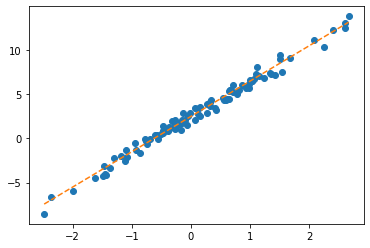

In [3]:
plt.plot(x,y,'o')
plt.plot(x,2.5+4*x,'--')

# 회귀모형에서 학습이란?

`-` 파란점만 주어졌을때, 주황색 점선을 추정하는것. 좀 더 정확하게 말하면
given data로 $\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}$를
최대한 $\begin{bmatrix} 2.5 \\ 4 \end{bmatrix}$와 비슷하게 찾는것.

-   given data : $\big\{(x_i,y_i) \big\}_{i=1}^{n}$

-   parameter: ${\bf W}=\begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$

-   estimated parameter:
    ${\bf \hat{W}}=\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}$

`-` 더 쉽게 말하면 아래의 그림을 보고 `적당한` 추세선을 찾는것이다.

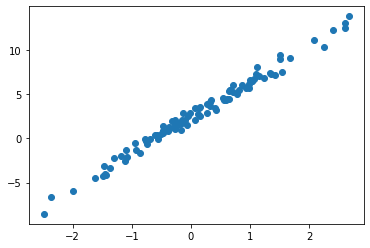

In [4]:
plt.plot(x,y,'o')

`-` 시도: $(\hat{w}_0,\hat{w}_1)=(-5,10)$을 선택하여 선을 그려보고
적당한지 판단.

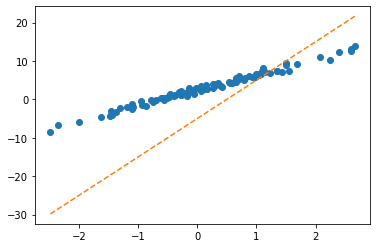

In [5]:
plt.plot(x,y,'o')
plt.plot(x,-5+10*x,'--')

-   $\hat{y}_i=-5 +10 x_i$ 와 같이 $y_i$의 값을 적합시키겠다는 의미

`-` 벡터표현으로 주황색점선을 계산

In [6]:
What = torch.tensor([-5.0,10.0])

In [7]:
X.shape

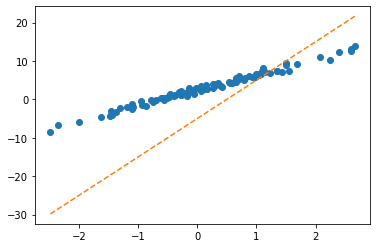

In [8]:
plt.plot(x,y,'o')
plt.plot(x,X@What,'--')

# 파라메터를 학습하는 방법 (적당한 선으로 업데이트 하는 방법)

`-` 이론적으로 추론 \<- 회귀분석시간에 배운것

`-` **컴퓨터의 반복계산을 이용하여 추론 (손실함수도입 + 경사하강법)**
\<- 우리가 오늘 파이토치로 실습해볼 내용.

`-` 전략: 아래와 같은 3단계 전략을 취한다.

-   stage1: 아무 점선이나 그어본다..
-   stage2: stage1에서 그은 점선보다 더 좋은 점선으로 바꾼다.
-   stage3: stage1 - 2 를 반복한다.

## ***Stage1: 첫번째 점선 – 임의의 선을 일단 그어보자***

`-` $\hat{w}_0=-5, \hat{w}_1 = 10$ 으로 설정하고 (왜? 그냥) 임의의 선을
그어보자.

In [9]:
What = torch.tensor([-5.0,10.0],requires_grad=True)
What

-   처음에는
    ${\bf \hat{W}}=\begin{bmatrix} \hat{w}_0 \\ \hat{w}_1 \end{bmatrix}=\begin{bmatrix} -5 \\ 10 \end{bmatrix}$
    를 대입해서 주황색 점선을 적당히 그려보자는 의미

-   끝에 requires_grad=True는 나중에 미분을 위한 것

In [10]:
yhat = X@What 

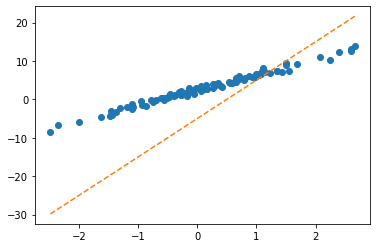

In [11]:
plt.plot(x,y,'o')
plt.plot(x,yhat.data,'--') # 그림을 그리기 위해서 yhat의 미분꼬리표를 제거

## ***Stage2: 첫번째 수정 – 최초의 점선에 대한 ‘적당한 정도’를 판단하고 더 ’적당한’ 점선으로 업데이트 한다.***

`-` ’적당한 정도’를 판단하기 위한 장치: loss function 도입!

$loss=\sum_{i=1}^{n}(y_i-\hat{y}_i)^2=\sum_{i=1}^{n}(y_i-(\hat{w}_0+\hat{w}_1x_i))^2$

$=({\bf y}-{\bf\hat{y}})^\top({\bf y}-{\bf\hat{y}})=({\bf y}-{\bf X}{\bf \hat{W}})^\top({\bf y}-{\bf X}{\bf \hat{W}})$

`-` loss 함수의 특징 - $y_i \approx \hat{y}_i$ 일수록 loss값이 작다. -
$y_i \approx \hat{y}_i$ 이 되도록 $(\hat{w}_0,\hat{w}_1)$을 잘 찍으면
loss값이 작다. - (중요) 주황색 점선이 ‘적당할 수록’ loss값이 작다.

In [12]:
loss = torch.sum((y-yhat)**2)
loss

`-` 우리의 목표: 이 loss(=8587.6875)을 더 줄이자. - 궁극적으로는 아예
모든 조합 $(\hat{w}_0,\hat{w}_1)$에 대하여 가장 작은 loss를 찾으면
좋겠다. (stage2에서 할일은 아님)

`-` 문제의 치환: 생각해보니까 우리의 문제는 아래와 같이 수학적으로
단순화 되었다. - 적당해보이는 주황색 선을 찾자 $\to$ $loss(w_0,w_1)$를
최소로하는 $(w_0,w_1)$의 값을 찾자.

`-` 수정된 목표: $loss(w_0,w_1)$를 최소로 하는 $(w_0,w_1)$을 구하라. -
단순한 수학문제가 되었다. 마치 $loss(w)=w^2-2w+3$ 을 최소화하는 $w$를
찾으라는 것과 같음. - 즉 “적당한 선으로 업데이트 하라 = 파라메터를 학습
하라 = 손실함수를 최소화 하라”

`-` 우리의 무기: 경사하강법, 벡터미분

------------------------------------------------------------------------

### `#` ***Stage2를 위한 경사하강법 복습***

**경사하강법 아이디어 (1차원)**

(step 1) 임의의 점을 찍는다.

(step 2) 그 점에서 순간기울기를 구한다. (접선) \<– 미분

(step 3) 순간기울기(=미분계수)의 부호를 살펴보고 부호와 반대방향으로
움직인다.

(팁) 기울기의 절대값 크기와 비례하여 보폭(=움직이는 정도)을 조절한다.

**경사하강법 아이디어 (2차원)**

(step 1) 임의의 점을 찍는다.

(step 2) 그 점에서 순간기울기를 구한다. (접평면) \<– 편미분

(step 3) 순간기울기(=미분계수)의 부호를 살펴보고 부호와 반대방향으로
각각 움직인다.

(팁) 기울기의 절대값 크기와 비례하여 보폭(=움직이는 정도)을 각각
조절한다.

**loss를 줄이도록 ${\bf W}$를 개선하는 방법**

`-` \$수정값 원래값 - 기울어진크기(=미분계수) \$

-   여기에서 $\alpha$는 전체적인 보폭의 크기를 결정한다. 즉 $\alpha$값이
    클수록 한번의 update에 움직이는 양이 크다.

`-`
${\bf W} \leftarrow {\bf W} - \alpha \times \frac{\partial}{\partial {\bf W}}loss(w_0,w_1)$

-   마이너스의 의미: 기울기의 부호를 보고 반대방향으로 움직여라.

-   $\frac{\partial}{\partial {\bf W}}loss(w_0,w_1):$ 기울기의 절대값
    크기와 비례하여 움직이는 정도를 조정하라.

-   $\alpha$의 의미: 전체적인 보폭의 속도를 조절, $\alpha$가 크면
    전체적으로 빠르게 움직인다. 다리의 길이로 비유할 수 있다.

------------------------------------------------------------------------

`-` 우리의 목표: loss=8587.6875 인데, 이걸 줄이는 것이 목표라고 했었음.
이것을 줄이는 방법이 경사하강법이다.

`-` 경사하강법으로 loss를 줄이기 위해서는
$\frac{\partial}{\partial {\bf W}}loss(w_0,w_1)$의 계산이 필요한데, 이를
위해서 벡터미분이 필요하다. (`loss.backward()`로 하면된다)

In [13]:
loss

In [14]:
loss.backward() 

-   loss.backward()의 의미: loss를 미분해라! 뭘로?
    `requires_grad=True`를 가진 텐서로!!

``` python
loss=torch.sum((y-yhat)**2)= torch.sum((y-X@What)**2)
# 이었고 
What=torch.tensor([-5.0,10.0],requires_grad=True)
# 이므로 결국 What으로 미분하라는 의미. 
# 미분한 식이 나오는 것이 아니고, 
# 그 식에 (-5.0, 10.0)을 대입한 계수값이 계산됨. 
```

`-` 위에서 `loss.backward()`의 과정은 미분을 활용하여 $(-5,10)$에서의
순간기울기를 구했다는 의미임.

`-` (-5,10)에서 loss의 순간기울기 값은 `What.grad`로 확인가능하다.

In [15]:
What,What.grad

-   이것이 의미하는건 $(-5,10)$에서의 $loss(w_0,w_1)$의 순간기울기가
    $(-1342.2523, 1188.9307)$ 이라는 의미

`-` (확인1) `loss.backward()`가 미분을 잘 계산해 주는 것이 맞는가?
손계산으로 검증하여 보자.

-   $loss(w_0,w_1)=({\bf y}-\hat{\bf y})^\top ({\bf y}-\hat{\bf y})=({\bf y}-{\bf XW})^\top ({\bf y}-{\bf XW})$

-   $\frac{\partial}{\partial {\bf W} }loss(w_0,w_1)=-2{\bf X}^\top {\bf y}+2{\bf X}^\top {\bf X W}$

In [16]:
- 2 * X.T @ y + 2 * X.T @ X @ What

`-` (확인2) `loss.backward()`가 미분을 잘 계산해 주는 것이 맞는가?
편미분을 간단히 구현하여 검증하여 보자.

-   $\frac{\partial}{\partial {\bf W} } loss(w_0,w_1)=\begin{bmatrix}\frac{\partial}{\partial w_0} \\ \frac{\partial}{\partial w_1} \end{bmatrix}loss(w_0,w_1) =\begin{bmatrix}\frac{\partial}{\partial w_0}loss(w_0,w_1) \\ \frac{\partial}{\partial w_1}loss(w_0,w_1) \end{bmatrix}$

-   $\frac{\partial}{\partial w_0}loss(w_0,w_1) \approx \frac{loss(w_0+h,w_1)-loss(w_0,w_1)}{h}$

-   $\frac{\partial}{\partial w_1}loss(w_0,w_1) \approx \frac{loss(w_0,w_1+h)-loss(w_0,w_1)}{h}$

In [17]:
_lossfn = lambda w0,w1: torch.sum((y-w0-w1*x)**2)
_lossfn(-5,10)

In [18]:
h=0.001
(_lossfn(-5+h,10) - _lossfn(-5,10))/h,  (_lossfn(-5,10+h) - _lossfn(-5,10))/h

-   약간 오차가 있지만 얼추비슷 $\to$ 잘 계산했다는 소리임

`-` 수정전, 수정하는폭, 수정후의 값은 차례로 아래와 같다.

In [19]:
alpha=0.001 
print('수정전: ' + str(What.data)) # What 에서 미분꼬리표를 떼고 싶다면? What.data or What.detach()
print('수정하는폭: ' +str(-alpha * What.grad))
print('수정후: ' +str(What.data-alpha * What.grad))
print('*참값: (2.5,4)' )

수정전: tensor([-5., 10.])
수정하는폭: tensor([ 1.3423, -1.1889])
수정후: tensor([-3.6577,  8.8111])
*참값: (2.5,4)

`-` Wbefore, Wafter 계산

In [20]:
Wbefore = What.data
Wafter = What.data- alpha * What.grad
Wbefore, Wafter

`-` Wbefore, Wafter의 시각화

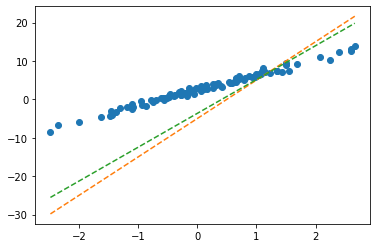

In [21]:
plt.plot(x,y,'o')
plt.plot(x,X@Wbefore,'--')
plt.plot(x,X@Wafter,'--')

## ***Stage3: Learn (=estimate $\bf\hat{W})$***

`-` 이 과정은 Stage1,2를 반복하면 된다.

In [22]:
What= torch.tensor([-5.0,10.0],requires_grad=True) #

In [23]:
alpha=0.001 
for epoc in range(30): ## 30번 반복합니다!! 
    yhat=X@What 
    loss=torch.sum((y-yhat)**2)
    loss.backward() 
    What.data = What.data-alpha * What.grad
    What.grad=None

-   원래 철자는 epoch이 맞아요

`-` 반복결과는?! (최종적으로 구해지는 What의 값은?!) - 참고로 true

In [24]:
What.data ## true인 (2.5,4)와 상당히 비슷함

`-` 반복결과를 시각화하면?

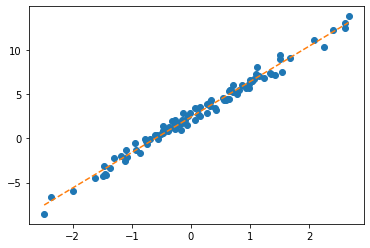

In [25]:
plt.plot(x,y,'o')
plt.plot(x,X@What.data,'--')

# 파라메터의 학습과정 음미 (학습과정 모니터링)

## 학습과정의 기록

`-` 기록을 해보자.

In [26]:
loss_history = [] # 기록하고 싶은것 1  
yhat_history = [] # 기록하고 싶은것 2 
What_history = [] # 기록하고 싶은것 3 

In [27]:
What= torch.tensor([-5.0,10.0],requires_grad=True)
alpha=0.001 
for epoc in range(30): 
    yhat=X@What ; yhat_history.append(yhat.data.tolist())
    loss=torch.sum((y-yhat)**2); loss_history.append(loss.item())
    loss.backward() 
    What.data = What.data-alpha * What.grad; What_history.append(What.data.tolist())
    What.grad=None

`-` $\hat{y}$ 관찰 (epoch=3, epoch=10, epoch=15)

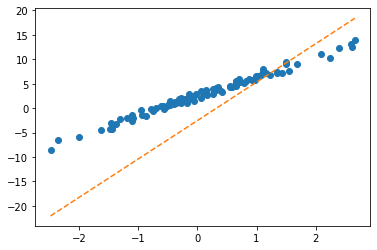

In [28]:
plt.plot(x,y,'o')
plt.plot(x,yhat_history[2],'--')

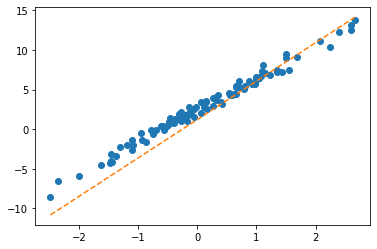

In [29]:
plt.plot(x,y,'o')
plt.plot(x,yhat_history[9],'--')

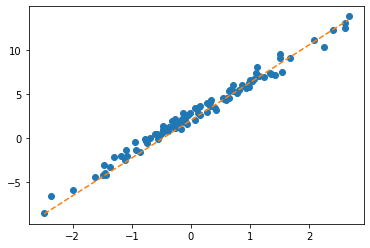

In [30]:
plt.plot(x,y,'o')
plt.plot(x,yhat_history[14],'--')

`-` $\hat{\bf W}$ 관찰

In [31]:
What_history

`-` loss 관찰

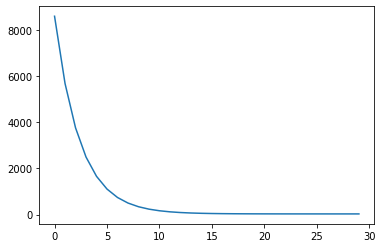

In [32]:
plt.plot(loss_history)

## 학습과정을 animation으로 시각화

In [33]:
from matplotlib import animation

In [34]:
plt.rcParams['figure.figsize'] = (7.5,2.5)
plt.rcParams["animation.html"] = "jshtml" 

`-` 왼쪽에는 $(x_i,y_i)$ and $(x_i,\hat{y}_i)$ 을 그리고 오른쪽에는
$loss(w_0,w_1)$ 을 그릴것임

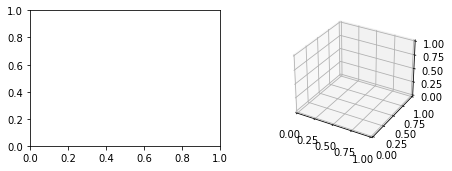

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

`-` 왼쪽그림!

In [36]:
ax1.plot(x,y,'o')
line, = ax1.plot(x,yhat_history[0]) # 나중에 애니메이션 할때 필요해요..

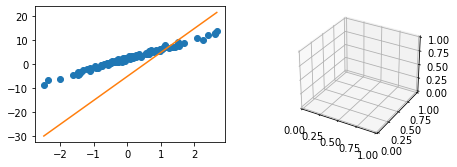

In [37]:
fig

`-` 오른쪽 그림1: $loss(w_0,w_1)$

In [38]:
_w0 = np.arange(-6, 11, 0.5) ## 파란색곡면을 그리는 코드 (시작) 
_w1 = np.arange(-6, 11, 0.5)
w1,w0 = np.meshgrid(_w1,_w0)
lss=w0*0
for i in range(len(_w0)):
    for j in range(len(_w1)):
        lss[i,j]=torch.sum((y-_w0[i]-_w1[j]*x)**2)
ax2.plot_surface(w0, w1, lss, rstride=1, cstride=1, color='b',alpha=0.35) ## 파란색곡면을 그리는 코드(끝) 
ax2.azim = 40  ## 3d plot의 view 조절 
ax2.dist = 8   ## 3d plot의 view 조절 
ax2.elev = 5   ## 3d plot의 view 조절 

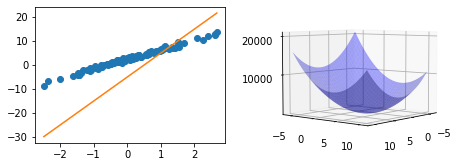

In [39]:
fig

`-` 오른쪽 그림2: $(w_0,w_1)=(2.5,4)$ 와 $loss(2.5,4)$ 값 \<- loss
함수가 최소가 되는 값 (이거 진짜야? ㅋㅋ)

In [40]:
ax2.scatter(2.5,4,torch.sum((y-2.5-4*x)**2),s=200,color='red',marker='*') ## 최소점을 표시하는 코드 (붉은색 별) 

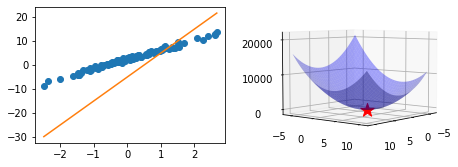

In [41]:
fig

`-` 오른쪽 그림3: $(w_0,w_1)=(-3.66, 8.81)$ 와 $loss(-3.66,8.81)$ 값

In [42]:
What_history[0]

In [43]:
ax2.scatter(What_history[0][0],What_history[0][1],loss_history[0],color='grey') ## 업데이트되는 What을 표시하는 점 (파란색 동그라미) 

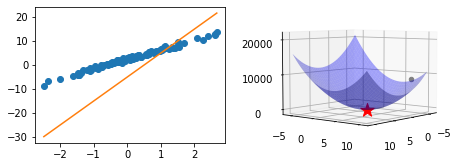

In [44]:
fig

`-` 애니메이션

In [45]:
def animate(epoc):
    line.set_ydata(yhat_history[epoc])
    ax2.scatter(What_history[epoc][0],What_history[epoc][1],loss_history[epoc],color='grey')
    return line

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

`-` 함수로 만들자..

In [46]:
def show_lrpr(data,history):
    x,y = data 
    loss_history,yhat_history,What_history = history 
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    ## ax1: 왼쪽그림 
    ax1.plot(x,y,'o')
    line, = ax1.plot(x,yhat_history[0]) 
    ## ax2: 오른쪽그림 
    _w0 = np.arange(-6, 11, 0.5) ## 파란색곡면을 그리는 코드 (시작) 
    _w1 = np.arange(-6, 11, 0.5)
    w1,w0 = np.meshgrid(_w1,_w0)
    lss=w0*0
    for i in range(len(_w0)):
        for j in range(len(_w1)):
            lss[i,j]=torch.sum((y-_w0[i]-_w1[j]*x)**2)
    ax2.plot_surface(w0, w1, lss, rstride=1, cstride=1, color='b',alpha=0.35) ## 파란색곡면을 그리는 코드(끝) 
    ax2.scatter(2.5,4,torch.sum((y-2.5-4*x)**2),s=200,color='red',marker='*') ## 최소점을 표시하는 코드 (붉은색 별) 
    ax2.scatter(What_history[0][0],What_history[0][1],loss_history[0],color='b') ## 업데이트되는 What을 표시하는 점 (파란색 동그라미) 
    ax2.azim = 40  ## 3d plot의 view 조절 
    ax2.dist = 8   ## 3d plot의 view 조절 
    ax2.elev = 5   ## 3d plot의 view 조절 

    def animate(epoc):
        line.set_ydata(yhat_history[epoc])
        ax2.scatter(np.array(What_history)[epoc,0],np.array(What_history)[epoc,1],loss_history[epoc],color='grey')
        return line

    ani = animation.FuncAnimation(fig, animate, frames=30)
    plt.close()
    return ani

In [47]:
show_lrpr([x,y],[loss_history,yhat_history,What_history])

# $\alpha$에 대하여 ($\alpha$는 학습률)

## (1) $\alpha=0.0001$: $\alpha$ 가 너무 작다면? $\to$ 비효율적이다.

In [48]:
loss_history = [] # 기록하고 싶은것 1  
yhat_history = [] # 기록하고 싶은것 2 
What_history = [] # 기록하고 싶은것 3 

In [49]:
What= torch.tensor([-5.0,10.0],requires_grad=True)
alpha=0.0001 
for epoc in range(30): 
    yhat=X@What ; yhat_history.append(yhat.data.tolist())
    loss=torch.sum((y-yhat)**2); loss_history.append(loss.item())
    loss.backward() 
    What.data = What.data-alpha * What.grad; What_history.append(What.data.tolist())
    What.grad=None

In [50]:
show_lrpr([x,y],[loss_history,yhat_history,What_history])

## (2) $\alpha=0.0083$: $\alpha$가 너무 크다면? $\to$ 다른의미에서 비효율적이다 + 위험하다..

In [51]:
loss_history = [] # 기록하고 싶은것 1  
yhat_history = [] # 기록하고 싶은것 2 
What_history = [] # 기록하고 싶은것 3 

In [52]:
What= torch.tensor([-5.0,10.0],requires_grad=True)
alpha=0.0083
for epoc in range(30): 
    yhat=X@What ; yhat_history.append(yhat.data.tolist())
    loss=torch.sum((y-yhat)**2); loss_history.append(loss.item())
    loss.backward() 
    What.data = What.data-alpha * What.grad; What_history.append(What.data.tolist())
    What.grad=None

In [53]:
show_lrpr([x,y],[loss_history,yhat_history,What_history])

## (3) $\alpha=0.0085$

In [54]:
loss_history = [] # 기록하고 싶은것 1  
yhat_history = [] # 기록하고 싶은것 2 
What_history = [] # 기록하고 싶은것 3 

In [55]:
What= torch.tensor([-5.0,10.0],requires_grad=True)
alpha=0.0085
for epoc in range(30): 
    yhat=X@What ; yhat_history.append(yhat.data.tolist())
    loss=torch.sum((y-yhat)**2); loss_history.append(loss.item())
    loss.backward() 
    What.data = What.data-alpha * What.grad.data; What_history.append(What.data.tolist())
    What.grad=None

In [56]:
show_lrpr([x,y],[loss_history,yhat_history,What_history])

## (4) $\alpha=0.01$

In [57]:
loss_history = [] # 기록하고 싶은것 1  
yhat_history = [] # 기록하고 싶은것 2 
What_history = [] # 기록하고 싶은것 3 

In [58]:
What= torch.tensor([-5.0,10.0],requires_grad=True)
alpha=0.01
for epoc in range(30): 
    yhat=X@What ; yhat_history.append(yhat.data.tolist())
    loss=torch.sum((y-yhat)**2); loss_history.append(loss.item())
    loss.backward() 
    What.data = What.data-alpha * What.grad; What_history.append(What.data.tolist())
    What.grad=None

In [59]:
show_lrpr([x,y],[loss_history,yhat_history,What_history])

# [숙제](https://ieilms.jbnu.ac.kr/)

`-` 학습률($\alpha$)를 조정하며 실습해보고 스크린샷 제출